<a href="https://colab.research.google.com/github/gitpds/MADS_Capstone/blob/main/Initial%20EDA%20Correlation%20Feature%20Engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rate Hike Rangers – Initial EDA

Fetch key series from FRED and explore basic relationships between:
- Consumer sentiment (UMCSENT)
- Fed funds rate (FEDFUNDS)
- 10-yr Treasury yield (GS10)
- House Price Index (CSUSHPINSA)
- **Home Purchase Sentiment Index (HPSI)**



In [2]:
#install & import dependencies
!pip install --quiet fredapi pandas numpy matplotlib seaborn statsmodels

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from fredapi import Fred
from statsmodels.tsa.stattools import adfuller

sns.set_style("whitegrid")


## 2) Connect to FRED


In [3]:
fred = Fred(api_key="58f9115272d30e7f68afcb31fbadd2b2")



In [4]:
start, end = "2000-01-01", "2024-12-31"

series = {
    "consumer_sentiment":      "UMCSENT",
    "fed_funds_rate":          "FEDFUNDS",
    "treasury_10y":            "GS10",
    "house_price_index":       "CSUSHPINSA",
    "home_purchase_sentiment": "FMNHSHPSIUS",
}

df = pd.DataFrame({
    name: fred.get_series(code, start, end)
    for name, code in series.items()
})
df.index = pd.to_datetime(df.index)
df = df.dropna()
print(f"Data from {df.index.min().date()} to {df.index.max().date()}")
df.head()


Data from 2011-03-01 to 2024-12-01


,consumer_sentiment,fed_funds_rate,treasury_10y,house_price_index,home_purchase_sentiment
2011-03-01,67.5,0.14,3.41,137.779,60.0
2011-04-01,69.8,0.10,3.46,139.153,62.5
2011-05-01,74.3,0.09,3.17,140.689,60.3
2011-06-01,71.5,0.09,3.00,141.942,61.0
2011-07-01,63.7,0.07,3.00,142.341,60.0


## 3) Quick overview
Shape, dtypes, summary stats, missing-value map.


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 166 entries, 2011-03-01 to 2024-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   consumer_sentiment       166 non-null    float64
 1   fed_funds_rate           166 non-null    float64
 2   treasury_10y             166 non-null    float64
 3   house_price_index        166 non-null    float64
 4   home_purchase_sentiment  166 non-null    float64
dtypes: float64(5)
memory usage: 7.8 KB
None


,consumer_sentiment,fed_funds_rate,treasury_10y,house_price_index,home_purchase_sentiment
count,166.00,166.00,166.00,166.00,166.00
mean,81.43,1.32,2.44,212.55,76.86
std,13.12,1.76,0.93,59.82,9.40
min,50.00,0.05,0.62,133.99,56.70
25%,71.55,0.09,1.78,166.49,69.80
50%,81.80,0.34,2.30,196.49,77.70
75%,93.57,1.94,2.90,264.39,83.78
max,101.40,5.33,4.80,325.67,93.80


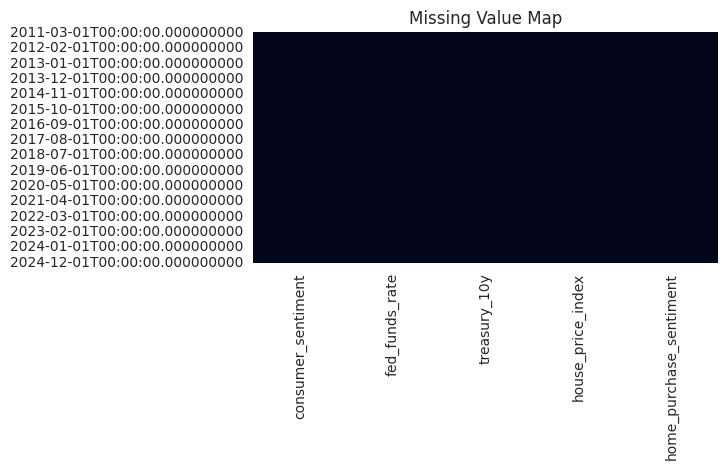

In [5]:
print(df.info())
display(df.describe().round(2))

plt.figure(figsize=(6,3))
sns.heatmap(df.isna(), cbar=False)
plt.title("Missing Value Map")
plt.show()


## 4) Time-series plots
Visualize each series over time.


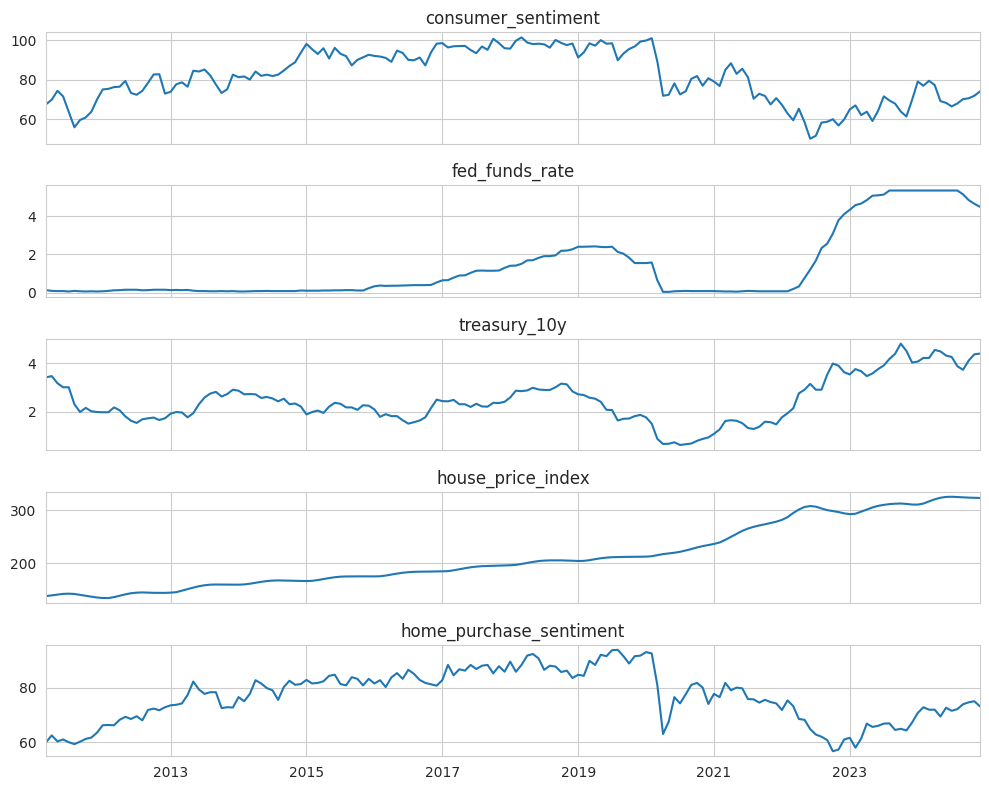

In [6]:
fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, 8), sharex=True)
for ax, col in zip(axes, df.columns):
    df[col].plot(ax=ax, title=col)
plt.tight_layout()
plt.show()


## 5) Correlation & Stationarity
Pairwise correlations and ADF test p-values.


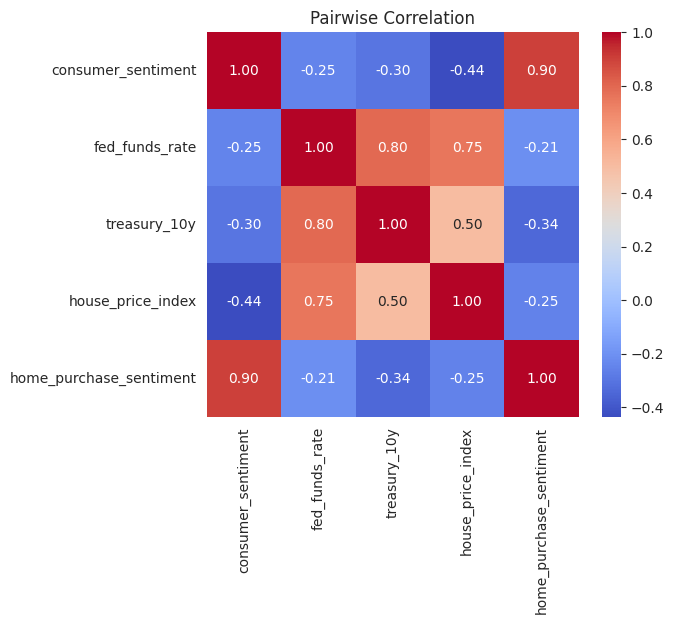

ADF p-values:
  consumer_sentiment: p=0.450
  fed_funds_rate: p=0.127
  treasury_10y: p=0.719
  house_price_index: p=0.969
  home_purchase_sentiment: p=0.132


In [7]:
plt.figure(figsize=(6,5))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Pairwise Correlation")
plt.show()

adf_pvals = {col: adfuller(df[col])[1] for col in df.columns}
print("ADF p-values:")
for k, v in adf_pvals.items():
    print(f"  {k}: p={v:.3f}")


## 6) Lagged correlations
Check which lags of sentiment align best with HPI.


In [8]:
lags = [1, 3, 6, 12]  # months
print("Sentiment ↔ HPI correlations at different lags:")
for lag in lags:
    corr = df["consumer_sentiment"].corr(df["house_price_index"].shift(lag))
    print(f"  {lag}-month lag: {corr:.2f}")


Sentiment ↔ HPI correlations at different lags:
  1-month lag: -0.45
  3-month lag: -0.47
  6-month lag: -0.50
  12-month lag: -0.57


## 8) Aligning Frequencies: Period-Grouping vs. As-Of Merge

Taking our mixed-frequency DataFrame `df` and producing two monthly versions:

1. **Period-Grouping**: convert to a PeriodIndex, aggregate per month, then ffill.  
2. **As-Of Merge**: build a strict monthly index and snap each series to the most recent prior observation, then ffill.  

Finally, then recompute the sentiment ↔ HPI lag correlations for each to see if there is improvement.


In [9]:
#PERIOD-GROUPING
df_period = df.copy()
df_period.index = df_period.index.to_period("M")
df_period_monthly = df_period.groupby(df_period.index).agg({
    "consumer_sentiment":      "mean",
    "fed_funds_rate":          "last",
    "treasury_10y":            "last",
    "house_price_index":       "mean",
    "home_purchase_sentiment": "mean"
})
df_period_monthly.index = df_period_monthly.index.to_timestamp()
df_period_monthly = df_period_monthly.ffill()

#AS-OF MERGE
# build a strict month-end index
monthly_idx = pd.date_range(df.index.min(), df.index.max(), freq="M")
monthly_df = pd.DataFrame(index=monthly_idx)

merged = monthly_df.copy()
for col in df.columns:
    temp = df[[col]].reset_index().rename(columns={"index": "date"}).sort_values("date")
    merged = pd.merge_asof(
        merged.reset_index().rename(columns={"index": "date"}),
        temp, on="date", direction="backward"
    ).set_index("date")

merged = merged.ffill()

#compare lag correlations
lags = [1, 3, 6, 12]
print("Sentiment ↔ HPI correlations at different lags:")
for lag in lags:
    c_period = df_period_monthly["consumer_sentiment"].corr(
        df_period_monthly["house_price_index"].shift(lag))
    c_asof   = merged["consumer_sentiment"].corr(
        merged["house_price_index"].shift(lag))
    print(f"  {lag}-month lag → period-grp: {c_period:.2f}, as-of: {c_asof:.2f}")


Sentiment ↔ HPI correlations at different lags:
  1-month lag → period-grp: -0.45, as-of: -0.45
  3-month lag → period-grp: -0.47, as-of: -0.46
  6-month lag → period-grp: -0.50, as-of: -0.50
  12-month lag → period-grp: -0.57, as-of: -0.57


/tmp/ipython-input-9-3725346546.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_idx = pd.date_range(df.index.min(), df.index.max(), freq="M")


## 8) Why both methods matched—and a forced resampling approach

Because we built `df` by dropping NA across all series, it collapsed to only those dates where every series had a value (in our case, month-ends), so Period-Grouping and As-Of Merge gave identical results.  

To see what’s really happening, we’ll:
1. Inspect the inferred frequency of each series in `df`.  
2. Pull the raw data (with NAs) into `raw` so we capture daily vs. monthly.  
3. Resample the daily series (FEDFUNDS, GS10) to month-end averages and join them with the true monthly series (UMCSENT, CSUSHPINSA, HPSI), then re-run our lag correlations.


In [10]:
# 1) Check what frequency Pandas thinks each column has
for col in df.columns:
    print(col, "→", df[col].index.inferred_freq)

# 2) Re-pull the raw series so we preserve daily vs. monthly
raw = pd.DataFrame({
    name: fred.get_series(code, start, end)
    for name, code in series.items()
})
raw.index = pd.to_datetime(raw.index)
print("\nRaw index range and NA counts:")
print(raw.info())
print(raw.isna().sum())

# 3) Forced resampling approach
#   - Daily series: FEDFUNDS, GS10 → monthly mean
#   - Monthly series: UMCSENT, CSUSHPINSA, HPSI → take first valid (they only have one per month)

daily_cols   = ["fed_funds_rate", "treasury_10y"]
monthly_cols = ["consumer_sentiment", "house_price_index", "home_purchase_sentiment"]

resampled = pd.DataFrame({
    col: raw[col].resample("M").mean()     for col in daily_cols
}).join(pd.DataFrame({
    col: raw[col].resample("M").first()    for col in monthly_cols
}))
resampled = resampled.ffill()

# 4) Recompute lagged correlations on this explicitly resampled DataFrame
lags = [1, 3, 6, 12]
print("\nForced resampling: Sentiment ↔ HPI correlations at different lags:")
for lag in lags:
    corr = resampled["consumer_sentiment"].corr(
        resampled["house_price_index"].shift(lag)
    )
    print(f"  {lag}-month lag: {corr:.2f}")


consumer_sentiment → MS
fed_funds_rate → MS
treasury_10y → MS
house_price_index → MS
home_purchase_sentiment → MS

Raw index range and NA counts:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 300 entries, 2000-01-01 to 2024-12-01
Freq: MS
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   consumer_sentiment       300 non-null    float64
 1   fed_funds_rate           300 non-null    float64
 2   treasury_10y             300 non-null    float64
 3   house_price_index        300 non-null    float64
 4   home_purchase_sentiment  166 non-null    float64
dtypes: float64(5)
memory usage: 14.1 KB
None
consumer_sentiment           0
fed_funds_rate               0
treasury_10y                 0
house_price_index            0
home_purchase_sentiment    134
dtype: int64

Forced resampling: Sentiment ↔ HPI correlations at different lags:
  1-month lag: -0.39
  3-month lag: -0.39
  6-month lag: -0.39

/tmp/ipython-input-10-3523667759.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  col: raw[col].resample("M").mean()     for col in daily_cols
/tmp/ipython-input-10-3523667759.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  col: raw[col].resample("M").first()    for col in monthly_cols


## 10) Restricting to HPSI Coverage & Handling Missing Values

Since HPSI begins later than our other series, let’s:
1. Trim our DataFrame to the first month HPSI appears.  
2. Forward-fill then backward-fill any remaining gaps (or choose to drop them).  
3. Recompute lagged correlations on this consistent window.


In [11]:
# 1) Find first valid HPSI date
first_hpsi = resampled["home_purchase_sentiment"].first_valid_index()
print("HPSI starts on:", first_hpsi.date())

# 2) Trim to HPSI coverage
df_hpsi = resampled.loc[first_hpsi:].copy()

# 3) Fill remaining gaps if desired
df_hpsi["home_purchase_sentiment"] = df_hpsi["home_purchase_sentiment"].ffill().bfill()

# 4) Recompute lagged correlations on this window
lags = [1, 3, 6, 12]
print("\nTrimmed & filled: Sentiment ↔ HPI correlations:")
for lag in lags:
    corr = df_hpsi["consumer_sentiment"].corr(df_hpsi["house_price_index"].shift(lag))
    print(f"  {lag}-month lag: {corr:.2f}")

# 5) (Optional) Look at percent-change features
pct = df_hpsi.pct_change().dropna()
print("\nPercent-change correlations (1-month):")
print(pct["consumer_sentiment"].corr(pct["house_price_index"]))


HPSI starts on: 2011-03-31

Trimmed & filled: Sentiment ↔ HPI correlations:
  1-month lag: -0.45
  3-month lag: -0.47
  6-month lag: -0.50
  12-month lag: -0.57

Percent-change correlations (1-month):
-0.18608021834966118


## 11) Feature engineering for modeling

-Create a new DataFrame with:

-Level features (and their lags)

-Percent-change features

-HPSI as an extra predictor


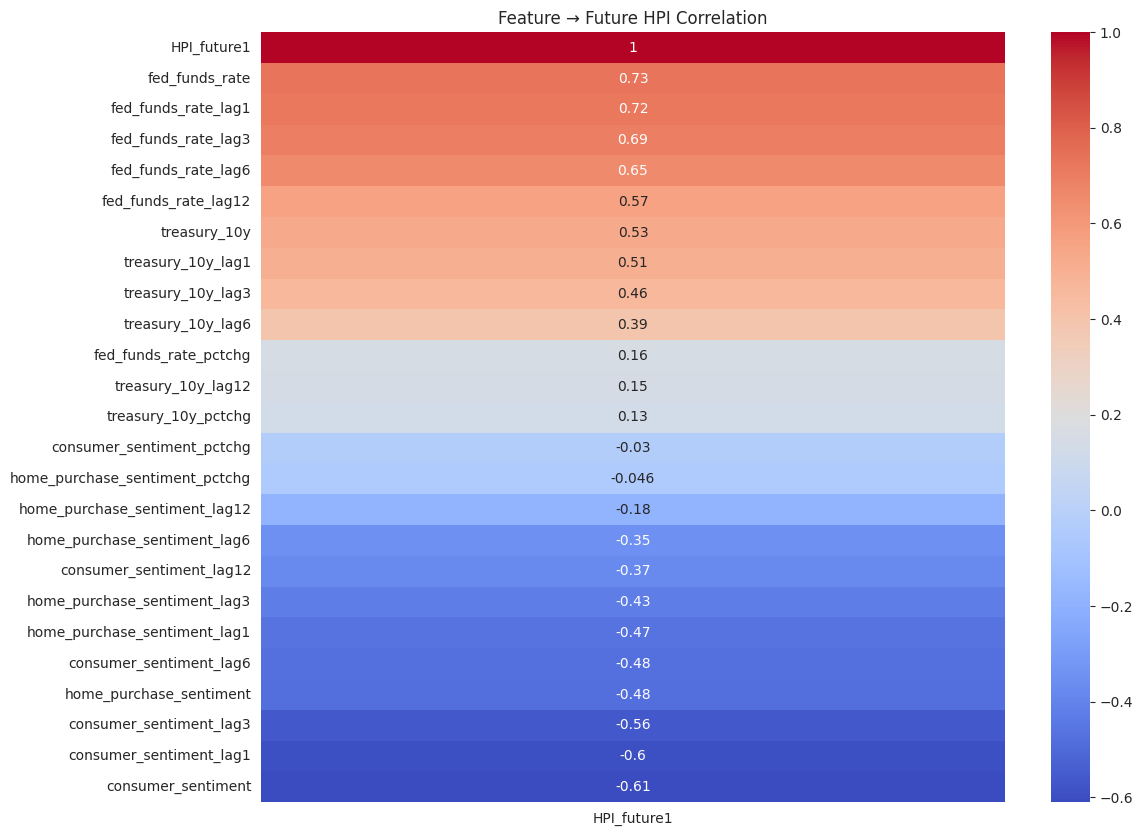

,consumer_sentiment,consumer_sentiment_lag1,consumer_sentiment_lag3,consumer_sentiment_lag6,consumer_sentiment_lag12,fed_funds_rate,fed_funds_rate_lag1,fed_funds_rate_lag3,fed_funds_rate_lag6,fed_funds_rate_lag12,...,home_purchase_sentiment,home_purchase_sentiment_lag1,home_purchase_sentiment_lag3,home_purchase_sentiment_lag6,home_purchase_sentiment_lag12,consumer_sentiment_pctchg,fed_funds_rate_pctchg,treasury_10y_pctchg,home_purchase_sentiment_pctchg,HPI_future1
2012-03-31,76.2,75.3,69.9,59.5,67.5,0.13,0.10,0.07,0.08,0.14,...,66.2,66.3,63.5,60.2,60.0,0.011952,0.300000,0.101523,-0.001508,138.463
2012-04-30,76.4,76.2,75.0,60.8,69.8,0.14,0.13,0.08,0.07,0.10,...,68.2,66.2,66.2,61.2,62.5,0.002625,0.076923,-0.055300,0.030211,141.039
2012-05-31,79.3,76.4,75.3,63.7,74.3,0.16,0.14,0.10,0.08,0.09,...,69.3,68.2,66.3,61.7,60.3,0.037958,0.142857,-0.121951,0.016129,143.161
2012-06-30,73.2,79.3,76.2,69.9,71.5,0.16,0.16,0.13,0.07,0.09,...,68.5,69.3,66.2,63.5,61.0,-0.076923,0.000000,-0.100000,-0.011544,144.274
2012-07-31,72.3,73.2,76.4,75.0,63.7,0.16,0.16,0.14,0.08,0.07,...,69.5,68.5,68.2,66.2,60.0,-0.012295,0.000000,-0.055556,0.014599,144.697


In [12]:
lags = [1, 3, 6, 12]

feat = pd.DataFrame(index=df_hpsi.index)

# 1) Add level and lagged-level features for sentiment, Fed rate, yield
for col in ["consumer_sentiment", "fed_funds_rate", "treasury_10y", "home_purchase_sentiment"]:
    feat[col] = df_hpsi[col]
    for lag in lags:
        feat[f"{col}_lag{lag}"] = df_hpsi[col].shift(lag)

# 2) Add month-over-month percent-change for each series
for col in ["consumer_sentiment", "fed_funds_rate", "treasury_10y", "home_purchase_sentiment"]:
    feat[f"{col}_pctchg"] = df_hpsi[col].pct_change()

# 3) Add your target: future HPI
#    e.g. HPI one month ahead (to turn it into a supervised problem)
feat["HPI_future1"] = df_hpsi["house_price_index"].shift(-1)

# 4) Drop rows with any NaNs (due to lags or pct_change)
feat = feat.dropna()

# 5) Quick correlation heatmap to spot strongest predictors
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(feat.corr()[["HPI_future1"]].sort_values("HPI_future1", ascending=False),
            annot=True, cmap="coolwarm")
plt.title("Feature → Future HPI Correlation")
plt.show()

# Now 'feat' is ready for train/test splits and modeling
feat.head()